In [97]:
import pandas as pd 
import csv
import spacy
import pt_core_news_sm
import string
import re

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from geopy import geocoders  
from time import time  
from collections import defaultdict
from gensim.models.phrases import Phrases, Phraser

import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [98]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [99]:
df = pd.read_csv(r'Vagas+Catho+Gupy+Indeed+LatitudeLongitude.csv')

In [100]:
df.head()

,Unnamed: 0,Cidade,Competências,Descrição_da_empresa,Empresa,Estado,Nome_da_vaga,Termo_pesquisado,Latitude,Longitude
0,0,brasilia,o cientista de dados ou data scientist e consi...,NaN,NaN,DF,vaga de cientista de dados em brasilia - df,cientista de dados,-15.793404,-47.882317
1,1,londrina,"utilizar modelos matematicos e estatisticos, p...",NaN,NaN,PR,vaga de cientista de dados em londrina - pr,cientista de dados,-23.311288,-51.159502
2,2,rio de janeiro,interpretacao de tendencias. refino de base de...,NaN,NaN,RJ,vaga de data scientist junior/ cientista de da...,cientista de dados,-22.911014,-43.209373
3,3,rio de janeiro,"modelar problemas complexos, identificar oport...",NaN,NaN,RJ,vaga de data scientist senior/ cientista de da...,cientista de dados,-22.911014,-43.209373
4,4,rio de janeiro,realizar projetos sprint de desenvolvimento e ...,NaN,NaN,RJ,vaga de cientista de dados (aut) em rio de jan...,cientista de dados,-22.911014,-43.209373


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 10 columns):
Unnamed: 0              2278 non-null int64
Cidade                  2278 non-null object
Competências            2278 non-null object
Descrição_da_empresa    541 non-null object
Empresa                 830 non-null object
Estado                  1509 non-null object
Nome_da_vaga            2278 non-null object
Termo_pesquisado        2278 non-null object
Latitude                2278 non-null float64
Longitude               2278 non-null float64
dtypes: float64(2), int64(1), object(7)
memory usage: 178.0+ KB


In [102]:
df.drop_duplicates(subset ="Competências", inplace = True) 

In [103]:
df = df.reset_index(drop=True)

In [104]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [105]:
df.groupby(['Termo_pesquisado']).count()

,Cidade,Competências,Descrição_da_empresa,Empresa,Estado,Nome_da_vaga,Latitude,Longitude
Termo_pesquisado,,,,,,,,
analista de dados,383,383,186,269,115,383,383,383
analista de negocios,205,205,145,205,0,205,205,205
analista de negocios,654,654,0,0,654,654,654,654
business analytics,17,17,4,5,12,17,17,17
business inteligence,8,8,3,4,4,8,8,8
cientista de dados,104,104,12,67,88,104,104,104
data analytics,27,27,19,27,2,27,27,27
data analytics,44,44,0,0,44,44,44,44
data science,62,62,8,12,52,62,62,62


In [106]:
#df.loc[df[col] == 'n', col] = 0
#df.rename(columns={'data scientist': 'cientista de dados'}, inplace = True)

In [107]:
termo_pesquisado = [
                    'cientista de dados',
                    'data science',
                    'data analytics',
                    'engenheiro de machine learning',
                    'analista de dados',
                    'engenheiro de dados',
                    'business inteligence',
                    'business analytics',
                    'analista de negocios',
                    'inteligencia de negocios'
                    ]

In [108]:
#termo1 = termo_pesquisado[0]
#termo2 = termo_pesquisado[1]
    
#df_science = df.loc[(df['Termo_pesquisado'] == termo)]
#df_analise = df.loc[(df['Termo_pesquisado'] == termo1) | (df['Termo_pesquisado'] == termo2)]
df_analise = df.copy()

In [109]:
df_analise.groupby(['Termo_pesquisado']).count()

,Cidade,Competências,Descrição_da_empresa,Empresa,Estado,Nome_da_vaga,Latitude,Longitude
Termo_pesquisado,,,,,,,,
analista de dados,383,383,186,269,115,383,383,383
analista de negocios,205,205,145,205,0,205,205,205
analista de negocios,654,654,0,0,654,654,654,654
business analytics,17,17,4,5,12,17,17,17
business inteligence,8,8,3,4,4,8,8,8
cientista de dados,104,104,12,67,88,104,104,104
data analytics,27,27,19,27,2,27,27,27
data analytics,44,44,0,0,44,44,44,44
data science,62,62,8,12,52,62,62,62


In [110]:
nlp = spacy.load('pt')

In [111]:
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [112]:
words = nlp(u'etc de a o que e do da em um para é com não uma os no se na por mais as dos como mas foi ao ele das tem à seu sua ou ser quando muito há nos já está eu também só pelo pela até isso ela entre era depois sem mesmo aos ter seus quem nas me esse eles estão você tinha foram essa num nem suas meu às minha têm numa pelos elas havia seja qual será nós tenho lhe deles essas esses pelas este fosse dele tu te vocês vos lhes meus minhas teu tua teus tuas nosso nossa nosso nossas dela delas esta estes estas aquele aquela aqueles aquelas isto aquilo estou está estamos estão estive esteve estivemos estiveram estava estávamos estavam estivera estivéramos esteja estejamos estejam estivesse estivéssemos estivessem estiver estivermos estiverem hei há havemos hão houve houvemos houveram houvera houvéramos haja hajamos hajam houvesse houvéssemos houvessem houver houvermos houverem houverei houverá houveremos houverão houveria houveríamos houveriam sou somos são era éramos eram fui foi fomos foram fora fôramos seja sejamos sejam fosse fôssemos fossem for formos forem serei será seremos serão seria seríamos seriam tenho tem temos tém tinha tínhamos tinham tive teve tivemos tiveram tivera tivéramos tenha tenhamos tenham tivesse tivéssemos tivessem tiver tivermos tiverem terei terá teremos terão teria teríamos teriam')
#words_sem_de = nlp(u'a o que e do da em um para é com não uma os no se na por mais as dos como mas foi ao ele das tem à seu sua ou ser quando muito há nos já está eu também só pelo pela até isso ela entre era depois sem mesmo aos ter seus quem nas me esse eles estão você tinha foram essa num nem suas meu às minha têm numa pelos elas havia seja qual será nós tenho lhe deles essas esses pelas este fosse dele tu te vocês vos lhes meus minhas teu tua teus tuas nosso nossa nosso nossas dela delas esta estes estas aquele aquela aqueles aquelas isto aquilo estou está estamos estão estive esteve estivemos estiveram estava estávamos estavam estivera estivéramos esteja estejamos estejam estivesse estivéssemos estivessem estiver estivermos estiverem hei há havemos hão houve houvemos houveram houvera houvéramos haja hajamos hajam houvesse houvéssemos houvessem houver houvermos houverem houverei houverá houveremos houverão houveria houveríamos houveriam sou somos são era éramos eram fui foi fomos foram fora fôramos seja sejamos sejam fosse fôssemos fossem for formos forem serei será seremos serão seria seríamos seriam tenho tem temos tém tinha tínhamos tinham tive teve tivemos tiveram tivera tivéramos tenha tenhamos tenham tivesse tivéssemos tivessem tiver tivermos tiverem terei terá teremos terão teria teríamos teriam')
words = [token.orth_ for token in words if not token.is_punct]
stopwords = frozenset(words)

In [113]:
words_ingles = nlp(u"bairesdev is seeking a tech lead to work with some of our most important clients in usa and europe. be part of an extraordinary opportunity to transform the higher experience! what we need? bairesdev is looking for a seasoned tech lead to join a stellar team working on it marketplace industry across the world. you will work with the developer and deliver & maintain critical software to serve clients, front office, and the general community to ensure excellent customer service experiences for all internal and external customers. you will have the opportunity to work on projects for companies that make a difference in each category. what we can offer you: one of our core values at bairesdev is to recognise and reward our staff as our greatest asset. we realise that it\'s our people who have built our outstanding reputation and that we will only maintain our leading position in the it world by continuing to attract and retain talented and motivated people. if you choose to come and work with us, you will find that we offer: excellent benefits and salary. a welcoming and inclusive environment. extensive development opportunities. stunning surroundings. remote work if this sounds great to you, please apply now. experience working with data scientist technology. experience business in software engineering. bairesdev is looking for a data scientist ssr/sr developer to work for a very important client in usa. this is a great opportunity for someone to be part of a rapid growth of a close knit team. this job offer is for full time and long term engagement, and you are allowed to work from your home. we love the rockstars, the self-taught geniuses, the niche specialists who know things almost no one knows. we love heads-down producers, the imaginative renegades, the go-to veterans who know what they know inside out. what we can offer you. one of our core values at bairesdev is to recognize and reward our staff as our greatest asset. we realise that it's our people who have built our outstanding reputation and that we will only maintain our leading position in the it world by continuing to attract and retain talented and motivated people. if you choose to come and work with us, you will find that we offer: excellent benefits and salary. a welcoming and inclusive environment. extensive development opportunities the minimum requirements are: data scientist experience working as a developer. proficient with analysis, troubleshooting, and problem solving. hands-on experience with managing data loads and data quality a plus. advanced english is mandatory")
words_ingles = [token.orth_ for token in words_ingles if not token.is_punct]
stopwords_ingles = frozenset(words_ingles)

In [114]:
df_analise['Termo_pesquisado'].replace(' ', '_', regex=True, inplace=True)
df_analise['Cidade'].replace(' ', '_', regex=True, inplace=True)
df_analise['Estado'].replace(' ', '_', regex=True, inplace=True)
df_analise = df_analise.assign(ConteudoTotal =  
                               df_analise['Termo_pesquisado'].astype(str) + ' ' +
#                               df_analise['Cidade'].astype(str) + ' ' +
#                               df_analise['Estado'].astype(str) + ' ' +
                               df_analise.Competências.astype(str))

# Select features from original dataset to form a new dataframe 
#>>> df1 = df[['Engine Fuel Type','Transmission Type','Driven_Wheels','Market Category','Vehicle Size', 'Vehicle Style', 'Maker_Model']]
# For each row, combine all the columns into one column
#>>> df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1)
# Store them in a pandas dataframe
#>>> df_clean = pd.DataFrame({'clean': df2})
# Create the list of list format of the custom corpus for gensim modeling 
#>>> sent = [row.split(',') for row in df_clean['clean']]
# show the example of list of list format of the custom corpus for gensim modeling 
#>>> sent[:2]
#[['premium unleaded (required)',
#  'MANUAL',
#  'rear wheel drive',
#  'Factory Tuner',
#  'Luxury',
#  'High-Performance',
#  'Compact',
#  'Coupe',
#  'BMW 1 Series M'],
# ['premium unleaded (required)',
#  'MANUAL',
#  'rear wheel drive',
#  'Luxury',
#  'Performance',
#  'Compact',
#  'Convertible',
#  'BMW 1 Series']]

In [115]:
df_analise.ConteudoTotal

0       cientista_de_dados o cientista de dados ou dat...
1       cientista_de_dados utilizar modelos matematico...
2       cientista_de_dados interpretacao de tendencias...
3       cientista_de_dados modelar problemas complexos...
4       cientista_de_dados realizar projetos sprint de...
5       cientista_de_dados desenvolvimento de software...
6       cientista_de_dados sprints adicionais / avulso...
7       cientista_de_dados modelar problemas complexos...
8       cientista_de_dados empresa   referencia em dat...
9       cientista_de_dados sera sua responsabilidade o...
10      cientista_de_dados *curso superior completo em...
11      cientista_de_dados programacao, de preferencia...
12      cientista_de_dados organizar e validar os dado...
13      cientista_de_dados adquirir, avaliar e process...
14      cientista_de_dados transformar as fontes de da...
15      cientista_de_dados - solucionar problemas de n...
16      cientista_de_dados ira atuar com ambientes de ...
17      cienti

In [116]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    # txt = [token.lemma_ for token in doc if not token.is_stop]
    txt = [token for token in doc]
#    txt = [token.lemma_ for token in txt]
    txt = [token.orth_ for token in txt]
    # txt = [token for token in txt if (token not in stopwords and token not in punctuations)]
    txt = [token for token in txt if (token not in stopwords and token not in stopwords_ingles)]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [117]:
#brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df2) #REGEX
brief_cleaning = (re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^`{|}~]', ' ', str(row)).lower() for row in df_analise.ConteudoTotal) #REGEX

In [118]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 5.14 mins


In [119]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(1664, 1)

In [120]:
df_clean['clean']

0       cientista_de_dados cientista dados considerado...
1       cientista_de_dados utilizar modelos matematico...
2       cientista_de_dados interpretacao tendencias   ...
3       cientista_de_dados modelar problemas complexos...
4       cientista_de_dados realizar projetos sprint de...
5       cientista_de_dados desenvolvimento   ajudar co...
6       cientista_de_dados sprints adicionais    avuls...
7       cientista_de_dados modelar problemas complexos...
8       cientista_de_dados empresa    referencia drive...
9       cientista_de_dados sera responsabilidade levan...
10      cientista_de_dados   curso superior completo e...
11      cientista_de_dados programacao   preferencia p...
12      cientista_de_dados organizar validar dados ger...
13      cientista_de_dados adquirir   avaliar processa...
14      cientista_de_dados transformar fontes dados in...
15      cientista_de_dados    solucionar problemas neg...
16      cientista_de_dados ira atuar ambientes alta cr...
17      cienti

In [121]:
sent = [row.split() for row in df_clean['clean']]

In [122]:
sent

[['cientista_de_dados',
  'cientista',
  'dados',
  'considerado',
  'nova',
  'geracao',
  'especialistas',
  'analise',
  'dados',
  'habilidades',
  'tecnicas',
  'resolver',
  'problemas',
  'complexos',
  'curiosidade',
  'explorar',
  'quais',
  'problemas',
  'necessitam',
  'solucao',
  'conhecimentos',
  'especificos',
  'linguagens',
  'programacao',
  'analise',
  'dados',
  'r',
  'python',
  'sql',
  'visualizacao',
  'dados',
  'spotfire',
  'powerbi',
  'cognos',
  'mining',
  'analise',
  'exploratoria',
  'dados',
  'infraestrutura',
  'big',
  'hadoop',
  'mapreduce',
  'spark',
  'algoritmos',
  'regressao',
  'logistica',
  'arvore',
  'decisao',
  'random',
  'forest',
  'xgbooster',
  'regressao',
  'linear',
  'notebook',
  'jupyter',
  'zepellin',
  'hive',
  'hbase',
  'etl',
  'datastage',
  'sqoop',
  'experiencia',
  'projetos',
  'analytics',
  'machine',
  'learning',
  'deep',
  'learning',
  'analise',
  'sentimentos',
  'analise',
  'conteudo',
  'nlp',

In [123]:
phrases = Phrases(sent, progress_per=10000)
#phrases = Phrases(sent, min_count=30, progress_per=10000)

#class gensim.models.phrases.Phrases(sentences=None, min_count=5, threshold=10.0, 
#max_vocab_size=40000000, delimiter='_', progress_per=10000, scoring='default', common_terms=frozenset([]))

#Detect phrases based on collocation counts.

#Parameters:	
#sentences (iterable of list of str, optional) – The sentences iterable can be simply a list, but for larger corpora, consider a generator that streams the sentences directly from disk/network, See BrownCorpus, Text8Corpus or LineSentence for such examples.
#min_count (float, optional) – Ignore all words and bigrams with total collected count lower than this value.
#threshold (float, optional) – Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.
#max_vocab_size (int, optional) – Maximum size (number of tokens) of the vocabulary. Used to control pruning of less common words, to keep memory under control. The default of 40M needs about 3.6GB of RAM. Increase/decrease max_vocab_size depending on how much available memory you have.
#delimiter (str, optional) – Glue character used to join collocation tokens, should be a byte string (e.g. b’_’).
#scoring ({'default', 'npmi', function}, optional) –

INFO - 14:44:25: collecting all words and their counts
INFO - 14:44:25: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 14:44:25: collected 89376 word types from a corpus of 132058 words (unigram + bigrams) and 1664 sentences
INFO - 14:44:25: using 89376 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [124]:
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 14:44:25: source_vocab length 89376
INFO - 14:44:26: Phraser built with 1083 phrasegrams


In [125]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

13168

In [126]:
word_freq

defaultdict(int,
            {'cientista_de_dados': 87,
             'cientista_dados': 14,
             'considerado': 2,
             'nova': 22,
             'geracao': 65,
             'especialistas': 14,
             'analise': 763,
             'dados': 1141,
             'habilidades_tecnicas': 9,
             'resolver_problemas': 23,
             'complexos': 24,
             'curiosidade_explorar': 6,
             'quais': 25,
             'problemas': 86,
             'necessitam': 7,
             'solucao': 79,
             'conhecimentos_especificos': 14,
             'linguagens_programacao': 60,
             'r_python': 28,
             'sql': 209,
             'visualizacao_dados': 25,
             'spotfire': 6,
             'powerbi': 25,
             'cognos': 10,
             'mining': 17,
             'analise_exploratoria': 8,
             'infraestrutura': 71,
             'big_hadoop': 13,
             'mapreduce_spark': 2,
             'algoritmos': 71,
      

In [127]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['experiencia',
 'conhecimento',
 'dados',
 'desenvolvimento',
 'analise',
 'area',
 'analista_de_negocios__',
 'vendas',
 'processos',
 'clientes']

In [128]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=5,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.05, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

#Os hiperparâmetros utilizados são:
#
#min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
#window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
#size = int - Dimensionality of the feature vectors. - (50, 300)
#sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
#alpha = float - The initial learning rate - (0.01, 0.05)
#min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
#negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no - negative sampling is used. - (5, 20)
#workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [129]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:44:27: collecting all words and their counts
INFO - 14:44:27: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:44:27: collected 13168 word types from a corpus of 115828 raw words and 1664 sentences
INFO - 14:44:27: Loading a fresh vocabulary
INFO - 14:44:27: effective_min_count=5 retains 4078 unique words (30% of original 13168, drops 9090)
INFO - 14:44:27: effective_min_count=5 leaves 101022 word corpus (87% of original 115828, drops 14806)
INFO - 14:44:27: deleting the raw counts dictionary of 13168 items
INFO - 14:44:27: sample=6e-05 downsamples 1385 most-common words
INFO - 14:44:27: downsampling leaves estimated 53617 word corpus (53.1% of prior 101022)
INFO - 14:44:27: estimated required memory for 4078 words and 300 dimensions: 11826200 bytes
INFO - 14:44:27: resetting layer weights


Time to build vocab: 0.01 mins


In [130]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:44:27: training model with 3 workers on 4078 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 14:44:28: worker thread finished; awaiting finish of 2 more threads
INFO - 14:44:28: worker thread finished; awaiting finish of 1 more threads
INFO - 14:44:28: worker thread finished; awaiting finish of 0 more threads
INFO - 14:44:28: EPOCH - 1 : training on 115828 raw words (53656 effective words) took 0.5s, 115789 effective words/s
INFO - 14:44:28: worker thread finished; awaiting finish of 2 more threads
INFO - 14:44:28: worker thread finished; awaiting finish of 1 more threads
INFO - 14:44:28: worker thread finished; awaiting finish of 0 more threads
INFO - 14:44:28: EPOCH - 2 : training on 115828 raw words (53625 effective words) took 0.4s, 151714 effective words/s
INFO - 14:44:28: worker thread finished; awaiting finish of 2 more threads
INFO - 14:44:28: worker thread finished; awaiting finish of 1 more threads
INFO - 14:44:28: worker thread

INFO - 14:44:36: EPOCH - 24 : training on 115828 raw words (53730 effective words) took 0.3s, 161996 effective words/s
INFO - 14:44:36: worker thread finished; awaiting finish of 2 more threads
INFO - 14:44:36: worker thread finished; awaiting finish of 1 more threads
INFO - 14:44:36: worker thread finished; awaiting finish of 0 more threads
INFO - 14:44:36: EPOCH - 25 : training on 115828 raw words (53652 effective words) took 0.4s, 127244 effective words/s
INFO - 14:44:36: worker thread finished; awaiting finish of 2 more threads
INFO - 14:44:36: worker thread finished; awaiting finish of 1 more threads
INFO - 14:44:36: worker thread finished; awaiting finish of 0 more threads
INFO - 14:44:36: EPOCH - 26 : training on 115828 raw words (53458 effective words) took 0.3s, 162107 effective words/s
INFO - 14:44:37: worker thread finished; awaiting finish of 2 more threads
INFO - 14:44:37: worker thread finished; awaiting finish of 1 more threads
INFO - 14:44:37: worker thread finished; aw

INFO - 14:44:45: EPOCH - 48 : training on 115828 raw words (53769 effective words) took 0.4s, 149463 effective words/s
INFO - 14:44:45: worker thread finished; awaiting finish of 2 more threads
INFO - 14:44:45: worker thread finished; awaiting finish of 1 more threads
INFO - 14:44:45: worker thread finished; awaiting finish of 0 more threads
INFO - 14:44:45: EPOCH - 49 : training on 115828 raw words (53557 effective words) took 0.4s, 141591 effective words/s
INFO - 14:44:45: worker thread finished; awaiting finish of 2 more threads
INFO - 14:44:45: worker thread finished; awaiting finish of 1 more threads
INFO - 14:44:45: worker thread finished; awaiting finish of 0 more threads
INFO - 14:44:45: EPOCH - 50 : training on 115828 raw words (53767 effective words) took 0.3s, 160094 effective words/s
INFO - 14:44:45: training on a 5791400 raw words (2682163 effective words) took 18.2s, 147522 effective words/s


Time to train the model: 0.3 mins


In [131]:
w2v_model.init_sims(replace=True)

INFO - 14:44:45: precomputing L2-norms of word weight vectors


In [132]:
w2v_model.wv.most_similar(positive=["cientista_de_dados"])

[('cientista_dados', 0.7654334306716919),
 ('procura', 0.7382429838180542),
 ('orientadas', 0.7257379293441772),
 ('alto_desempenho', 0.7147100567817688),
 ('ibope', 0.7085455656051636),
 ('veja', 0.6980475783348083),
 ('curiosidade_explorar', 0.6978819370269775),
 ('responsabilidades_atribuicoes', 0.6970630884170532),
 ('facilidade_aprender', 0.6892307996749878),
 ('paixao', 0.6860598921775818)]

In [133]:
w2v_model.wv.most_similar(positive=["data_science"])

[('arquitetar', 0.7560141086578369),
 ('engenheiro_de_machine_learning', 0.715339720249176),
 ('profissional_ira', 0.7135565876960754),
 ('n_posicao', 0.7024961709976196),
 ('profissional_sera', 0.6941479444503784),
 ('desafio', 0.6845198273658752),
 ('data_analytics__', 0.6800904273986816),
 ('engenheiro_de_dados__', 0.6588519811630249),
 ('data_analytics', 0.6584548950195312),
 ('sera_responsavel', 0.640405535697937)]

In [134]:
w2v_model.wv.most_similar(positive=["analista_de_dados"])

[('analista_de_dados_analista', 0.792852520942688),
 ('desenvolvedor', 0.7730259299278259),
 ('resumo', 0.7593057751655579),
 ('analista_de_negocios', 0.7100722789764404),
 ('analista', 0.6860215663909912),
 ('analista_de_dados_descricao', 0.6572046279907227),
 ('back_end', 0.6388989090919495),
 ('compor', 0.6341534852981567),
 ('busca_analista', 0.628646194934845),
 ('analista_de_dados_principais', 0.6191225647926331)]

In [135]:
w2v_model.wv.most_similar(positive=["engenheiro_de_dados"])

[('instrumentacao', 0.6918364763259888),
 ('disciplina', 0.6808309555053711),
 ('sob_orientacao', 0.6407232880592346),
 ('desenvolvedores', 0.626656174659729),
 ('engenheiro', 0.6199914216995239),
 ('eletrica', 0.6104263663291931),
 ('requisito', 0.6014989614486694),
 ('analista_de_negocios_descricao', 0.5996841192245483),
 ('atividades_serem', 0.5984649658203125),
 ('atividades', 0.5924893617630005)]

In [136]:
w2v_model.wv.most_similar(positive=["engenheiro_de_machine_learning"])

[('essence', 0.7663007974624634),
 ('engineer', 0.7656086683273315),
 ('junior', 0.7524913549423218),
 ('business_inteligence', 0.72850501537323),
 ('data_science', 0.715339720249176),
 ('about', 0.7053377628326416),
 ('arquitetar', 0.674137532711029),
 ('infra', 0.6714513897895813),
 ('success', 0.6632250547409058),
 ('responsible', 0.6554754972457886)]

In [137]:
w2v_model.wv.most_similar(positive=["business_inteligence"])

[('engenheiro_de_machine_learning', 0.72850501537323),
 ('essence', 0.7068830728530884),
 ('candidatar', 0.6860030889511108),
 ('junior', 0.6800309419631958),
 ('unico', 0.6781930923461914),
 ('berrini', 0.6763314604759216),
 ('procura', 0.6756587028503418),
 ('vaga', 0.6747366786003113),
 ('veja', 0.6711481809616089),
 ('programador', 0.6666432023048401)]

In [138]:
w2v_model.wv.most_similar(positive=["business_analytics"])

[('analyst', 0.7235217690467834),
 ('role', 0.720797598361969),
 ('junior', 0.712975025177002),
 ('responsible', 0.6796457767486572),
 ('into', 0.6756807565689087),
 ('level', 0.6756571531295776),
 ('partner', 0.6705873608589172),
 ('value', 0.668986976146698),
 ('coordenacao', 0.6645389795303345),
 ('product', 0.6531296372413635)]

In [139]:
w2v_model.wv.most_similar(positive=["analista_de_negocios"])

[('responsabilidades', 0.7786227464675903),
 ('analista', 0.7748855352401733),
 ('inteligencia_de_negocios', 0.7188928723335266),
 ('analista_de_dados', 0.7100722789764404),
 ('resumo', 0.7071923017501831),
 ('principais_atividades', 0.7040460705757141),
 ('desempenhadas', 0.6855056881904602),
 ('recrutamento_selecao', 0.6821919679641724),
 ('data_analytics', 0.6814224720001221),
 ('n_posicao', 0.6789757013320923)]

In [140]:
w2v_model.wv.most_similar(positive=["data_analytics"])

[('analista', 0.7630190849304199),
 ('analista_de_negocios', 0.6814224720001221),
 ('data_science', 0.6584548950195312),
 ('inteligencia_de_negocios', 0.651028037071228),
 ('principais_responsabilidades', 0.6465047597885132),
 ('posicao', 0.638733983039856),
 ('busca_analista', 0.636829137802124),
 ('junior', 0.6258366107940674),
 ('compor', 0.6237842440605164),
 ('berrini', 0.6216273307800293)]

In [141]:
w2v_model.wv.similarity("cientista_de_dados", "data_science")

0.638319

In [142]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
#    for wrd_score in close_words:
#        wrd_vector = model.wv.__getitem__([wrd_score[0]])
#        word_labels.append(wrd_score[0])
#        color_list.append('blue')
#        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=8).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

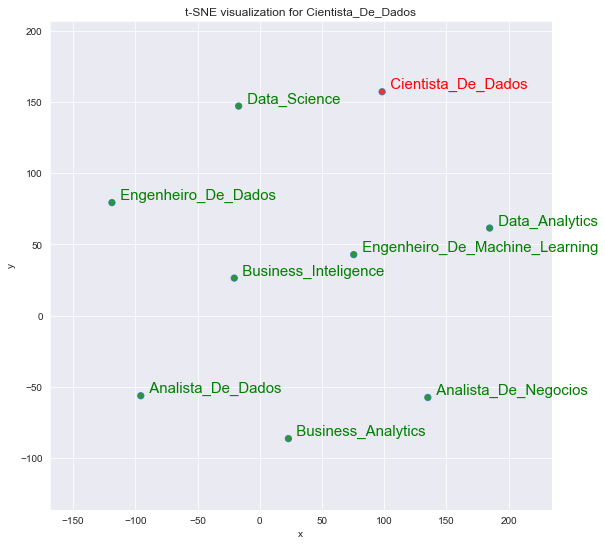

In [143]:
tsnescatterplot(w2v_model, "cientista_de_dados", ["data_science", "business_analytics","business_inteligence","engenheiro_de_machine_learning",'analista_de_dados', 'data_analytics', 'engenheiro_de_dados', 'analista_de_negocios'])

In [ ]:
tsnescatterplot(w2v_model, "cientista_de_dados", [t[0] for t in w2v_model.wv.most_similar(positive=["cientista_de_dados"], topn=20)][10:])